# Кластерный анализ данные смешанного типа

#### Данные: dataset_realty_1.csv

In [1217]:
# загрузка библиотек
# import os 
# os.environ["OMP_NUM_THREADS"] = "2" # для избежания проблем с memory leak и методом k-means
# # нужно писать до загрузки библиотеки numpy, чтобы найстройка применилась

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1218]:
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [1219]:
# для избежания warning при запуске команд
import warnings 
warnings.filterwarnings('ignore')

In [1220]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

## Подготовка данных 

In [1222]:
# загрузка данных

df = pd.read_csv("dataset_realty_1_1.csv", sep = ";", encoding = 'utf8', decimal = ",")
df['Дата брони'] = pd.to_datetime(df['Дата брони'], format = '%d.%m.%Y')
df['Дата рождения'] = pd.to_datetime(df['Дата рождения'], format = '%d.%m.%Y')
df.head()

,Номер документа,Основной клиент,Дата рождения,Проект,Тип объекта,Объект недвижимости,Подтип,Площадь,Сумма договора,Вариант оплаты,Дата брони,Состояние,Город
0,Пр12_Об2244_2448,Клиент 1779,1986-09-10,Проект 12,Нежилое,Пр12_Об2244,Кладовая,1.9,62738,100%,2023-02-04,Действующий,Санкт-Петербург
1,Пр4_Об1458_1559,Клиент 1149,1982-08-20,Проект 4,Нежилое,Пр4_Об1458,Кладовая,2.0,65192,Рассрочка,2023-10-20,Действующий,Санкт-Петербург
2,Пр4_Об447_456,Клиент 204,1987-07-23,Проект 4,Нежилое,Пр4_Об447,Кладовая,2.0,65490,100%,2024-06-03,Действующий,Санкт-Петербург
3,Пр12_Об1853_2016,Клиент 1462,1984-06-22,Проект 12,Нежилое,Пр12_Об1853,Кладовая,2.0,67607,Рассрочка,2023-06-18,Действующий,Санкт-Петербург
4,Пр12_Об2475_2694,Клиент 1640,1963-03-10,Проект 12,Нежилое,Пр12_Об2475,Кладовая,2.0,86222,100%,2023-02-04,Действующий,Санкт-Петербург


In [1223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2645 entries, 0 to 2644
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Номер документа      2645 non-null   object        
 1   Основной клиент      2645 non-null   object        
 2   Дата рождения        2645 non-null   datetime64[ns]
 3   Проект               2645 non-null   object        
 4   Тип объекта          2645 non-null   object        
 5   Объект недвижимости  2645 non-null   object        
 6   Подтип               2645 non-null   object        
 7   Площадь              2645 non-null   float64       
 8   Сумма договора       2645 non-null   int64         
 9   Вариант оплаты       2645 non-null   object        
 10  Дата брони           2645 non-null   datetime64[ns]
 11  Состояние            2645 non-null   object        
 12  Город                2645 non-null   object        
dtypes: datetime64[ns](2), float64(1),

In [1224]:
df_c = df['Площадь'].corr(df['Сумма договора'])
df_c

0.9174817022638886

In [1225]:
df['Цена за м2'] = round(df['Сумма договора'] / df['Площадь'], 3)

In [1226]:
#удаление признаков
df = df.drop(columns = ['Номер документа', 'Объект недвижимости', 'Основной клиент', 'Дата брони', 'Дата рождения', 'Проект', 'Площадь', 'Сумма договора'])
df

,Тип объекта,Подтип,Вариант оплаты,Состояние,Город,Цена за м2
0,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,33020.000
1,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,32596.000
2,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,32745.000
3,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,33803.500
4,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,43111.000
...,...,...,...,...,...,...
2640,Квартира,1к,100%,Регистрация,Москва,407371.195
2641,Квартира,Евро-4,Ипотека,Регистрация,Санкт-Петербург,297054.684
2642,Квартира,2к,Ипотека,Регистрация,Казань,361478.586
2643,Квартира,Евро-2,Рассрочка,Регистрация,Санкт-Петербург,269474.811


In [1227]:
df['Тип объекта'].value_counts()

Тип объекта
Нежилое        1146
Машиноместо     701
Квартира        688
Апартаменты     110
Name: count, dtype: int64

In [1228]:
df['Вариант оплаты'].value_counts()

Вариант оплаты
100%         1176
Ипотека       749
Рассрочка     720
Name: count, dtype: int64

In [1229]:
df['Состояние'].value_counts()

Состояние
Действующий     1420
Закрыт           861
Подписание       232
Не состоялся     102
Расторгнут        17
Регистрация       13
Name: count, dtype: int64

In [1230]:
df['Город'].value_counts()

Город
Санкт-Петербург    1927
Москва              452
Нижний Новгород     195
Казань               71
Name: count, dtype: int64

In [1231]:
df.head()

,Тип объекта,Подтип,Вариант оплаты,Состояние,Город,Цена за м2
0,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,33020.0
1,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,32596.0
2,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,32745.0
3,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,33803.5
4,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,43111.0


In [1232]:
df.describe()

,Цена за м2
count,2645.000000
mean,134791.055978
std,137779.600308
min,1938.776000
25%,34320.000000
50%,50926.786000
75%,246141.495000
max,794680.833000


In [1233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2645 entries, 0 to 2644
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Тип объекта     2645 non-null   object 
 1   Подтип          2645 non-null   object 
 2   Вариант оплаты  2645 non-null   object 
 3   Состояние       2645 non-null   object 
 4   Город           2645 non-null   object 
 5   Цена за м2      2645 non-null   float64
dtypes: float64(1), object(5)
memory usage: 124.1+ KB


## Иерархический кластерный анализ с метрикой Gower

### Подготовка

In [1236]:
# стандартизация количественных переменных
scaler = preprocessing.MinMaxScaler()
df1 = df.copy()
scaler.fit(df1[['Цена за м2']])
df1[['Цена за м2']] = scaler.transform(df[['Цена за м2']])

In [1237]:
df1.describe()

,Цена за м2
count,2645.000000
mean,0.167586
std,0.173801
min,0.000000
25%,0.040847
50%,0.061796
75%,0.308048
max,1.000000


In [1238]:
#pip install gower

Статья:
<i> Gower, John C. "A general coefficient of similarity and some of its properties." Biometrics (1971): 857-871.

https://www.jstor.org/stable/2528823?casa_token=RcJvu1av0bEAAAAA%3AJ1BN6rWo14PzlB_sOd6cx_xkN4kxNjr3EfHti5AmL6-6O4qgfMb8WnncKc_2AJzKL7aaDOI8Df3lpvC9Ucf7aN8i_sAB3D3N_USxn0QRpgHBObwGOQ

Метрика Говера (Gower) - специальная метрика, используемая для измерения расстояния в датасетах с данными смешанного типа.

Обзор метрик расстояния для данных смешанного типа:

<i> Bishnoi, S., & Hooda, B. K. (2020). A survey of distance measures for mixed variables. International Journal of Chemical Studies, 8(4), 338-343.

In [1242]:
import gower

In [1243]:
X = np.asarray(df1)
dist_matrix = gower.gower_matrix(X) # матрица расстояний 

In [1244]:
dist_matrix.shape

(2645, 2645)

In [1245]:
# преобразование матрицы расстоянии в condensed матрицу расстояний
from scipy.spatial.distance import squareform
cdist_matrix = squareform(dist_matrix)

# см. https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html

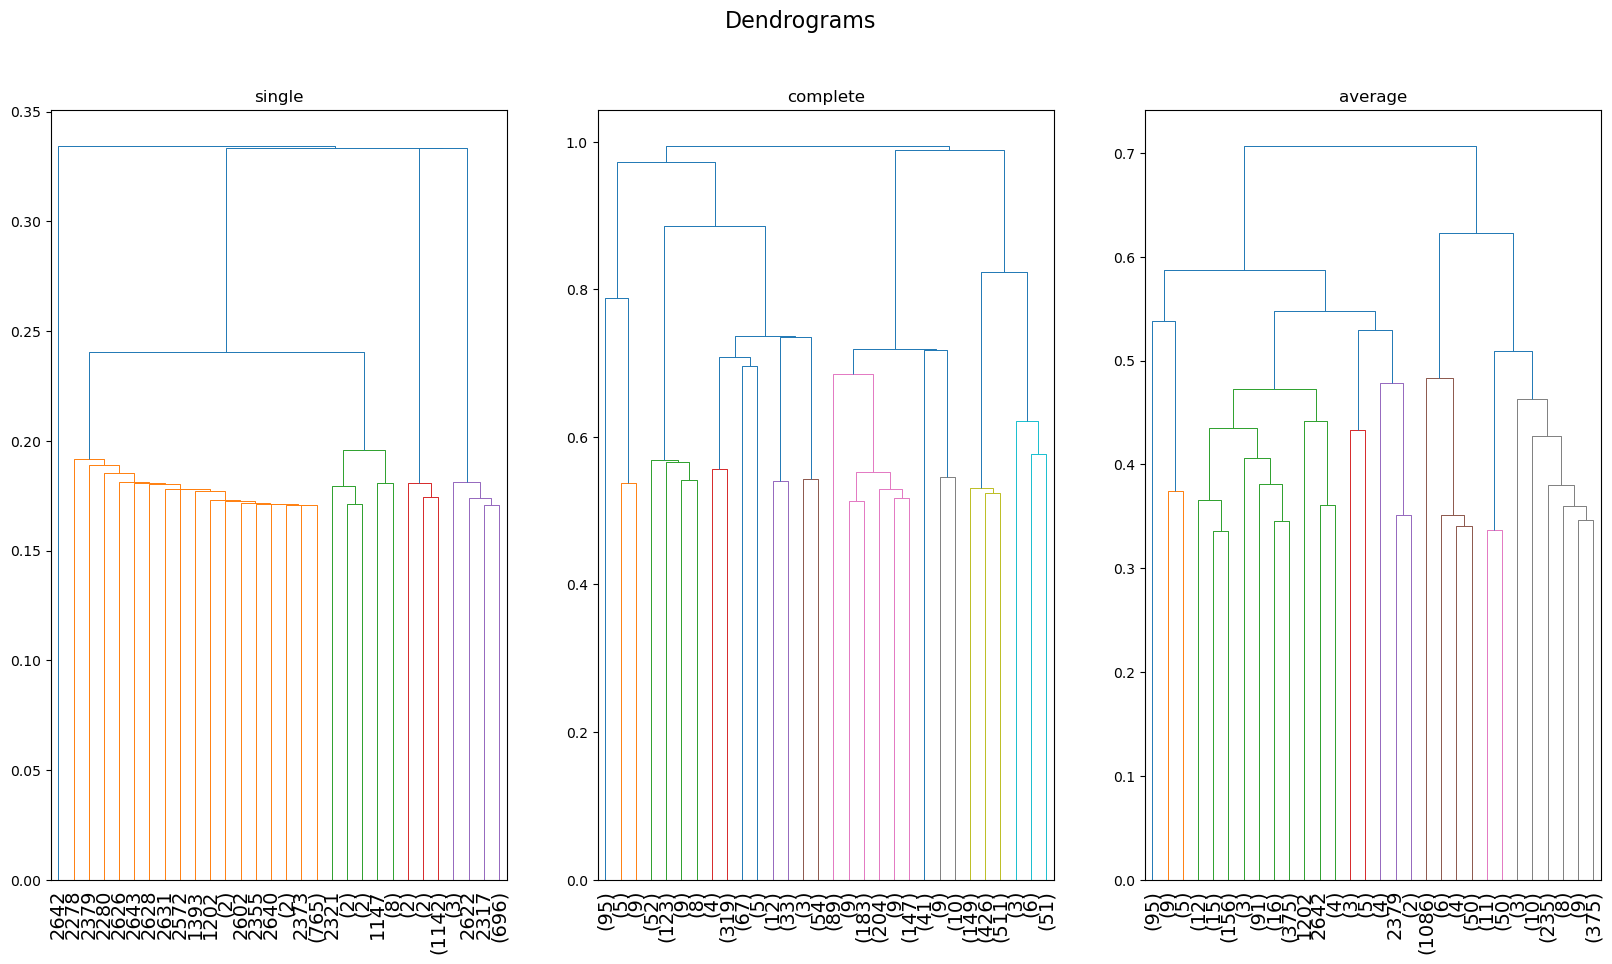

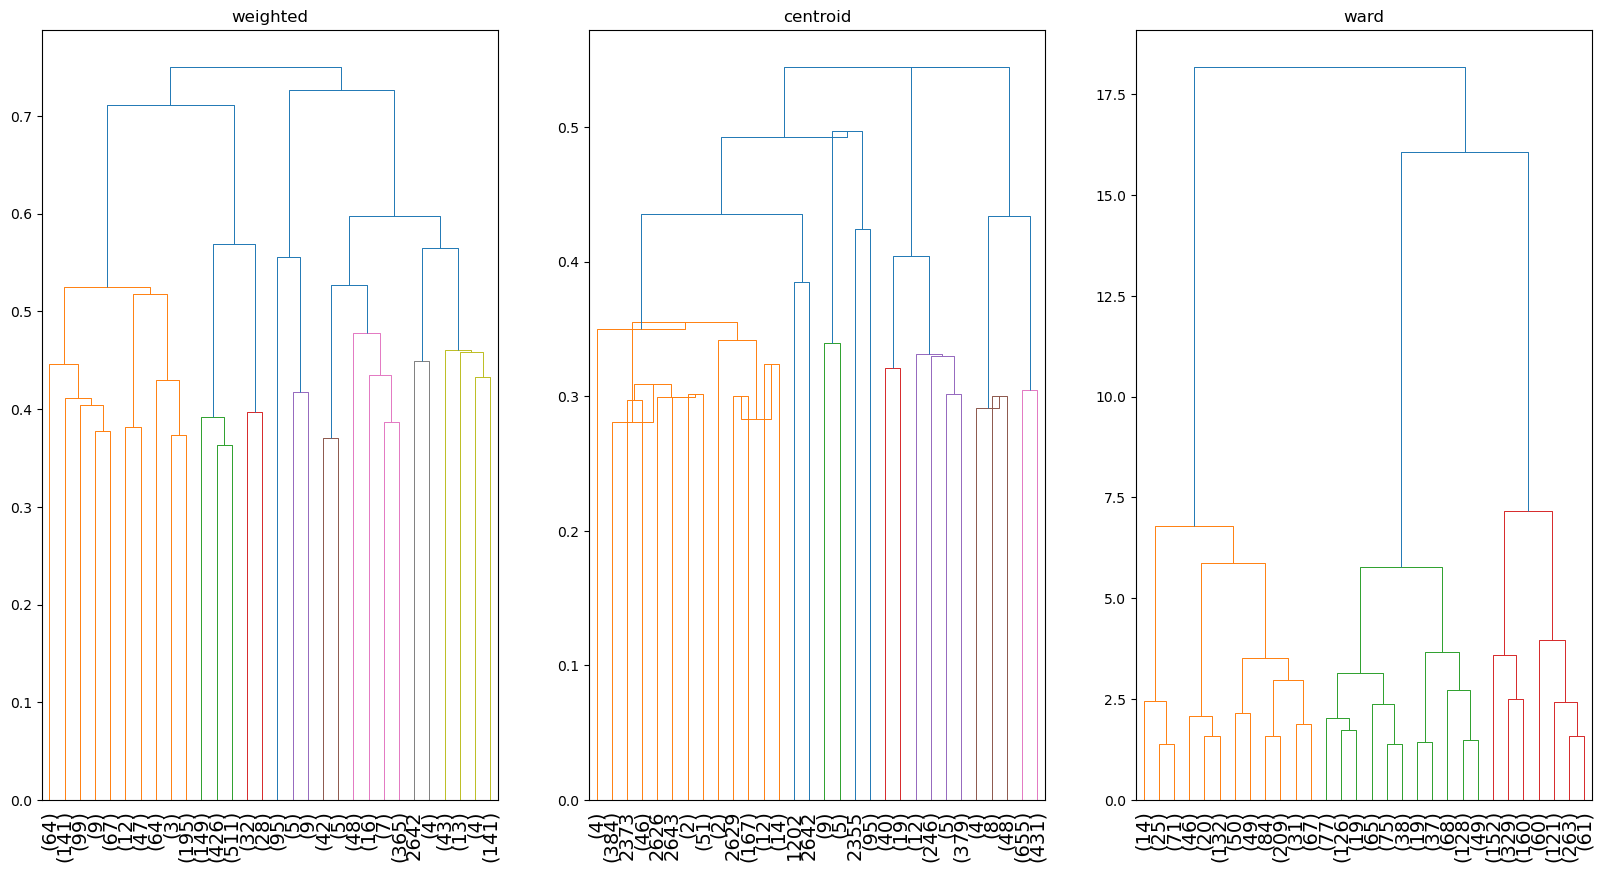

In [1246]:
# построение дендрограмм
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

fig.suptitle('Dendrograms', fontsize = 16)
link_methods = ['single', 'complete', 'average']

for i, item in zip(range(3), link_methods): 
        Z = linkage(cdist_matrix, item)
        dn = dendrogram(Z,
               leaf_rotation=90,  
               leaf_font_size=14,
                truncate_mode='lastp', # при большом количестве данных дендрограмму можно подрезать
               ax=axes[i])
        axes[i].set_title(item)
        
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
link_methods = ['weighted', 'centroid', 'ward']

for i, item in zip(range(3), link_methods): 
        Z = linkage(cdist_matrix, item)
        dn = dendrogram(Z,
               leaf_rotation=90,  
               leaf_font_size=14,
                truncate_mode='lastp',
               ax=axes[i])
        axes[i].set_title(item)

### Метод варда

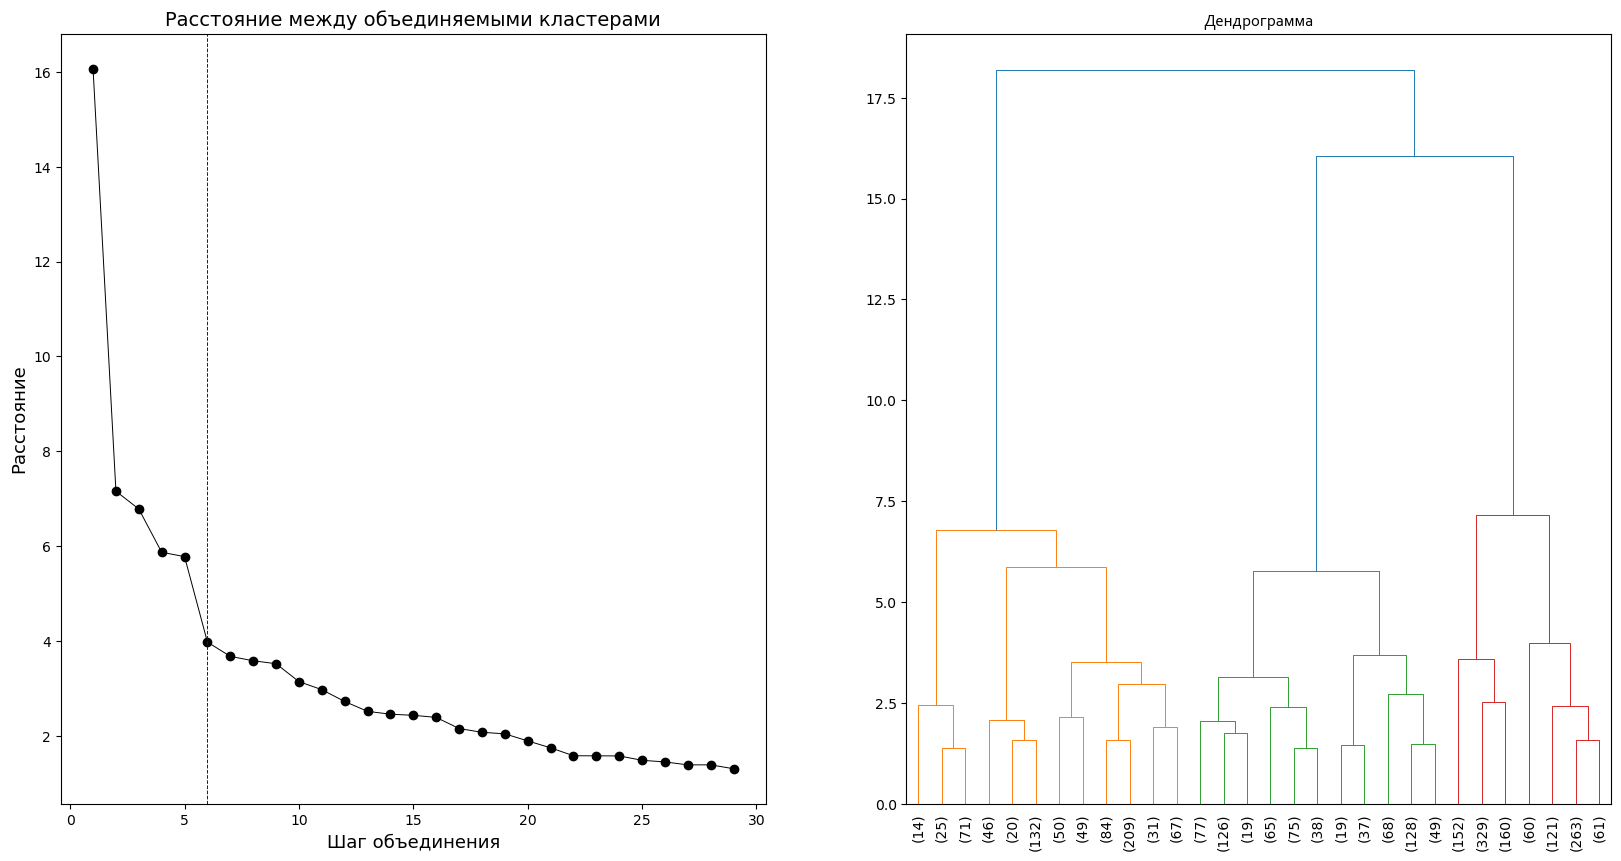

In [1375]:
Z = linkage(cdist_matrix, 'ward')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# Построение каменистой осыпи
dist= Z[:, 2]
dist_rev = dist[::-1]
dist_rev_30 = dist_rev[1:30]
idxs = range(1, 30)
ax[0].plot(idxs, dist_rev_30, marker='o', color = 'k')
ax[0].axvline(x = 6, color = 'b', linestyle = '--')
ax[0].set_title('Расстояние между объединяемыми кластерами', fontsize = 14)
ax[0].set_xlabel('Шаг объединения', fontsize = 13)
ax[0].set_ylabel('Расстояние', fontsize = 13)
ax[0].grid(False)

plt.rcParams['lines.linewidth'] = 0.7
font = {'fontname': 'Corbel', 'weight': 'normal', 'color':'black'}
plt.title('Дендрограмма', fontsize = 12, **font)

dn = dendrogram(Z,
               leaf_rotation=90,  
               leaf_font_size=10,
               truncate_mode='lastp',
               ax = ax[1])
plt.show()

In [1377]:
# Добавим переменную с номерами кластеров
df['cluster'] = fcluster(Z, t = 5.8, criterion='distance')
gower_ward = df['cluster']
df

,Тип объекта,Подтип,Вариант оплаты,Состояние,Город,Цена за м2,cluster
0,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,33020.000,5
1,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,32596.000,6
2,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,32745.000,5
3,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,33803.500,6
4,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,43111.000,5
...,...,...,...,...,...,...,...
2640,Квартира,1к,100%,Регистрация,Москва,407371.195,2
2641,Квартира,Евро-4,Ипотека,Регистрация,Санкт-Петербург,297054.684,3
2642,Квартира,2к,Ипотека,Регистрация,Казань,361478.586,2
2643,Квартира,Евро-2,Рассрочка,Регистрация,Санкт-Петербург,269474.811,3


In [1379]:
categorical_cols = ['Тип объекта', 'Подтип', 'Вариант оплаты', 'Состояние', 'Город']
numeric_cols = ['Цена за м2']

# Средние числовые значения
print(df.groupby('cluster')[numeric_cols].mean())

# Мода категориальных
print(df.groupby('cluster')[categorical_cols].agg(lambda x: x.mode()[0]))


            Цена за м2
cluster               
1        307028.361055
2        373007.868919
3        291317.088665
4         59652.389258
5         42561.561858
6         73366.348186
         Тип объекта       Подтип Вариант оплаты    Состояние            Город
cluster                                                                       
1        Апартаменты       Студия      Рассрочка  Действующий  Санкт-Петербург
2           Квартира       Евро-2        Ипотека  Действующий           Москва
3           Квартира           1к        Ипотека  Действующий  Санкт-Петербург
4        Машиноместо  Стандартное           100%       Закрыт  Санкт-Петербург
5            Нежилое     Кладовая           100%       Закрыт  Санкт-Петербург
6            Нежилое     Кладовая      Рассрочка  Действующий  Санкт-Петербург


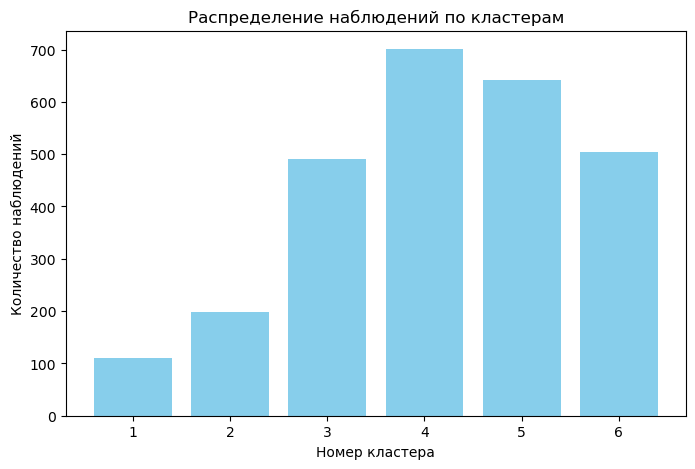

In [1381]:
# Подсчёт количества наблюдений в каждом кластере
cluster_counts = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel("Номер кластера")
plt.ylabel("Количество наблюдений")
plt.title("Распределение наблюдений по кластерам")
plt.xticks(cluster_counts.index)
plt.show()

In [1383]:
counts = df.groupby(['cluster', 'Тип объекта']).size().reset_index(name='count')
counts

,cluster,Тип объекта,count
0,1,Апартаменты,110
1,2,Квартира,198
2,3,Квартира,490
3,4,Машиноместо,701
4,5,Нежилое,641
5,6,Нежилое,505


In [1385]:
counts = df.groupby(['cluster', 'Подтип']).size().reset_index(name='count')
counts

,cluster,Подтип,count
0,1,2к,1
1,1,Евро-2,6
2,1,Евро-3,3
3,1,Студия,100
4,2,1к,50
5,2,2к,32
6,2,3к,11
7,2,4к,1
8,2,Евро-2,61
9,2,Евро-3,27


In [1387]:
counts = df.groupby(['cluster', 'Вариант оплаты']).size().reset_index(name='count')
counts

,cluster,Вариант оплаты,count
0,1,100%,22
1,1,Ипотека,35
2,1,Рассрочка,53
3,2,100%,14
4,2,Ипотека,172
5,2,Рассрочка,12
6,3,100%,50
7,3,Ипотека,385
8,3,Рассрочка,55
9,4,100%,421


In [1389]:
counts = df.groupby(['cluster', 'Состояние']).size().reset_index(name='count')
counts

,cluster,Состояние,count
0,1,Действующий,84
1,1,Не состоялся,17
2,1,Подписание,7
3,1,Расторгнут,2
4,2,Действующий,144
5,2,Закрыт,1
6,2,Не состоялся,30
7,2,Подписание,17
8,2,Расторгнут,3
9,2,Регистрация,3


In [1391]:
counts = df.groupby(['cluster', 'Город']).size().reset_index(name='count')
counts

,cluster,Город,count
0,1,Казань,14
1,1,Санкт-Петербург,96
2,2,Казань,1
3,2,Москва,194
4,2,Нижний Новгород,3
5,3,Казань,1
6,3,Москва,2
7,3,Нижний Новгород,1
8,3,Санкт-Петербург,486
9,4,Казань,50


In [1253]:
# удаляем столбец с номерами кластеров
df = df.drop(['cluster'], axis = 1)

### Метод average

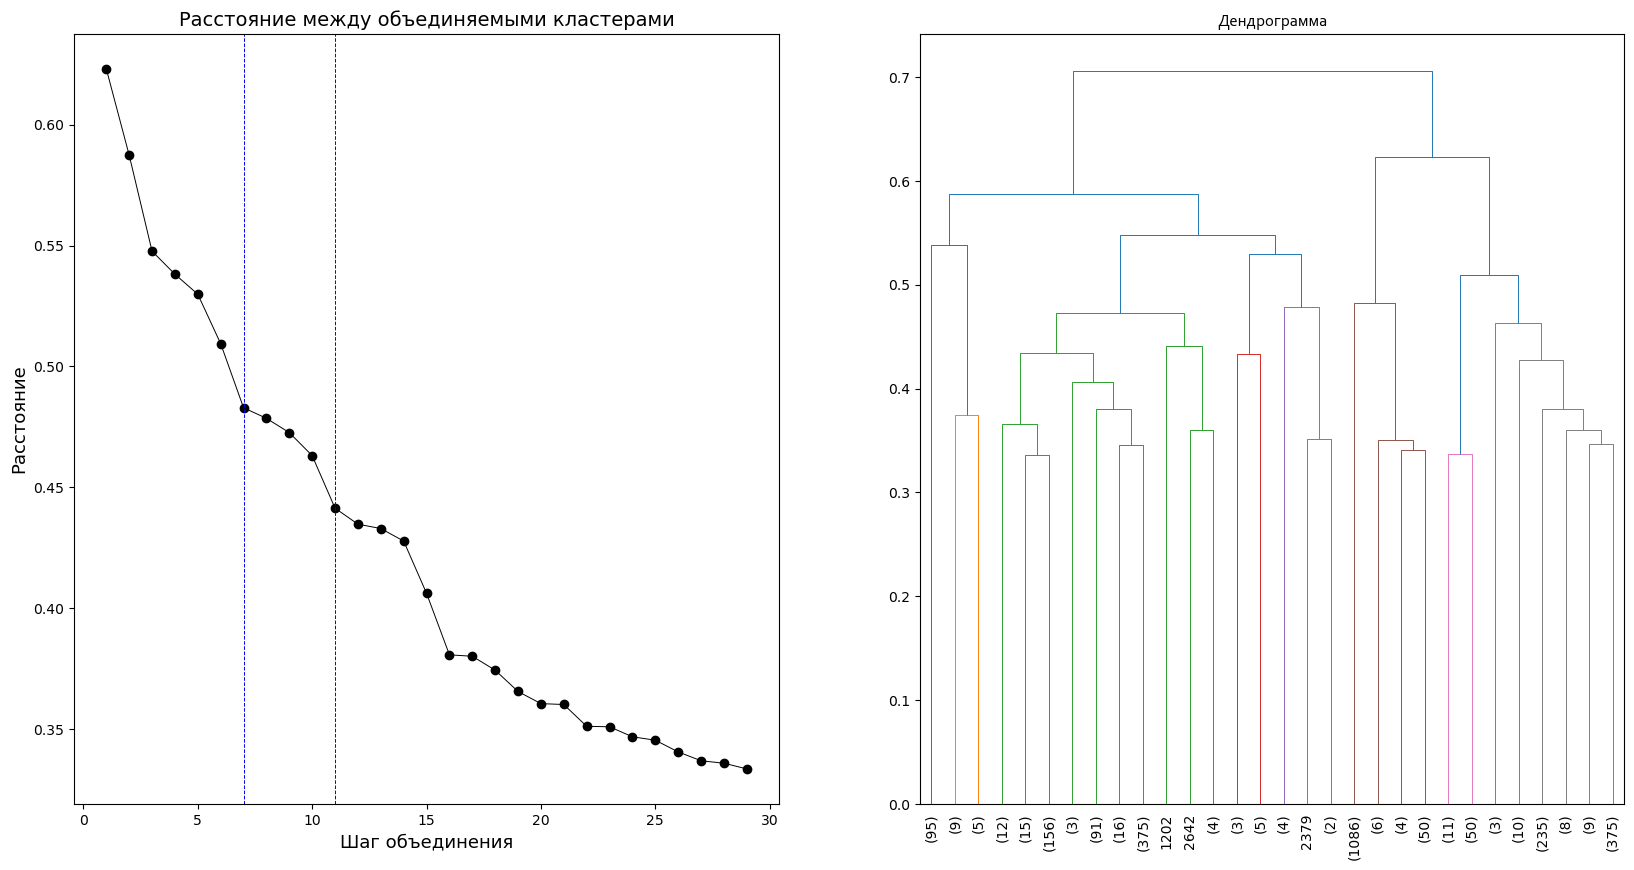

In [1255]:
Z = linkage(cdist_matrix, 'average')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# Построение каменистой осыпи
dist= Z[:, 2]
dist_rev = dist[::-1]
dist_rev_30 = dist_rev[1:30]
idxs = range(1, 30)
ax[0].plot(idxs, dist_rev_30, marker='o', color = 'k')
ax[0].axvline(x = 7, color = 'b', linestyle = '--')
ax[0].axvline(x = 11, color = 'b', linestyle = '--')
ax[0].set_title('Расстояние между объединяемыми кластерами', fontsize = 14)
ax[0].set_xlabel('Шаг объединения', fontsize = 13)
ax[0].set_ylabel('Расстояние', fontsize = 13)
ax[0].grid(False)

plt.rcParams['lines.linewidth'] = 0.7
font = {'fontname': 'Corbel', 'weight': 'normal', 'color':'black'}
plt.title('Дендрограмма', fontsize = 12, **font)

dn = dendrogram(Z,
               leaf_rotation=90,  
               leaf_font_size=10,
               truncate_mode='lastp',
               ax = ax[1])
plt.show()

##### 7 кластеров

In [1257]:
# Добавим переменную с номерами кластеров
df['cluster'] = fcluster(Z, t = 0.51, criterion='distance')
gower_ward = df['cluster']
df

,Тип объекта,Подтип,Вариант оплаты,Состояние,Город,Цена за м2,cluster
0,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,33020.000,6
1,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,32596.000,6
2,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,32745.000,6
3,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,33803.500,6
4,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,43111.000,6
...,...,...,...,...,...,...,...
2640,Квартира,1к,100%,Регистрация,Москва,407371.195,3
2641,Квартира,Евро-4,Ипотека,Регистрация,Санкт-Петербург,297054.684,3
2642,Квартира,2к,Ипотека,Регистрация,Казань,361478.586,3
2643,Квартира,Евро-2,Рассрочка,Регистрация,Санкт-Петербург,269474.811,3


In [1258]:
categorical_cols = ['Тип объекта', 'Подтип', 'Вариант оплаты', 'Состояние', 'Город']
numeric_cols = ['Цена за м2']

# Средние числовые значения
print(df.groupby('cluster')[numeric_cols].mean())

# Мода категориальных
print(df.groupby('cluster')[categorical_cols].agg(lambda x: x.mode()[0]))


            Цена за м2
cluster               
1        249933.953084
2        692365.537714
3        314129.255089
4        293763.167500
5        409140.695286
6         56136.096846
7         59652.389258
         Тип объекта       Подтип Вариант оплаты     Состояние  \
cluster                                                          
1        Апартаменты       Студия      Рассрочка   Действующий   
2        Апартаменты       Евро-2           100%   Действующий   
3           Квартира           1к        Ипотека   Действующий   
4           Квартира           1к           100%    Подписание   
5           Квартира           1к      Рассрочка  Не состоялся   
6            Нежилое     Кладовая           100%   Действующий   
7        Машиноместо  Стандартное           100%        Закрыт   

                   Город  
cluster                   
1        Санкт-Петербург  
2                 Казань  
3        Санкт-Петербург  
4        Санкт-Петербург  
5                 Москва  
6        

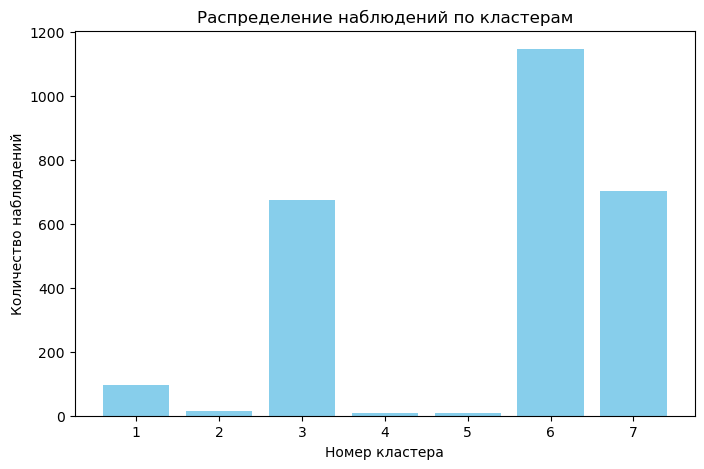

In [1259]:
# Подсчёт количества наблюдений в каждом кластере
cluster_counts = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel("Номер кластера")
plt.ylabel("Количество наблюдений")
plt.title("Распределение наблюдений по кластерам")
plt.xticks(cluster_counts.index)
plt.show()

In [1260]:
# удаляем столбец с номерами кластеров
df = df.drop(['cluster'], axis = 1)

##### 11 кластеров

In [1262]:
# Добавим переменную с номерами кластеров
df['cluster'] = fcluster(Z, t = 0.47, criterion='distance')
gower_ward = df['cluster']
df

,Тип объекта,Подтип,Вариант оплаты,Состояние,Город,Цена за м2,cluster
0,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,33020.000,8
1,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,32596.000,8
2,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,32745.000,8
3,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,33803.500,8
4,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,43111.000,8
...,...,...,...,...,...,...,...
2640,Квартира,1к,100%,Регистрация,Москва,407371.195,3
2641,Квартира,Евро-4,Ипотека,Регистрация,Санкт-Петербург,297054.684,3
2642,Квартира,2к,Ипотека,Регистрация,Казань,361478.586,4
2643,Квартира,Евро-2,Рассрочка,Регистрация,Санкт-Петербург,269474.811,3


In [1263]:
categorical_cols = ['Тип объекта', 'Подтип', 'Вариант оплаты', 'Состояние', 'Город']
numeric_cols = ['Цена за м2']

# Средние числовые значения
print(df.groupby('cluster')[numeric_cols].mean())

# Мода категориальных
print(df.groupby('cluster')[categorical_cols].agg(lambda x: x.mode()[0]))

            Цена за м2
cluster               
1        249933.953084
2        692365.537714
3        314425.163865
4        281184.744667
5        293763.167500
6        449766.227250
7        354973.319333
8         42152.698537
9        309235.606233
10        41779.607721
11        61355.888748
         Тип объекта       Подтип Вариант оплаты     Состояние  \
cluster                                                          
1        Апартаменты       Студия      Рассрочка   Действующий   
2        Апартаменты       Евро-2           100%   Действующий   
3           Квартира           1к        Ипотека   Действующий   
4           Квартира           2к        Ипотека   Действующий   
5           Квартира           1к           100%    Подписание   
6           Квартира           1к      Рассрочка  Не состоялся   
7           Квартира           3к      Рассрочка        Закрыт   
8            Нежилое     Кладовая           100%        Закрыт   
9            Нежилое    Коммерция      Ра

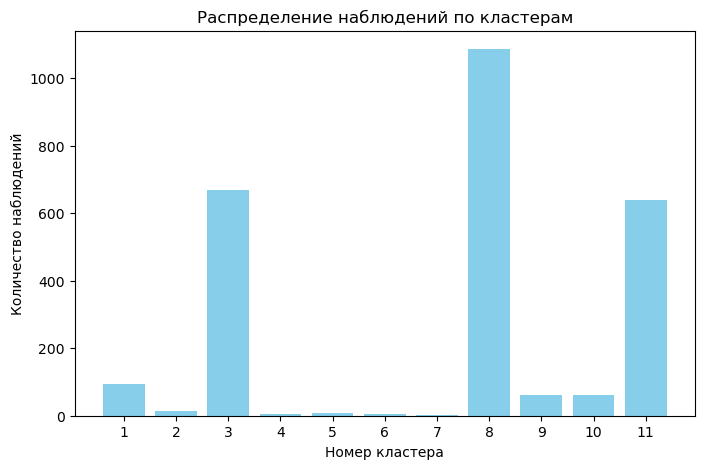

In [1264]:
# Подсчёт количества наблюдений в каждом кластере
cluster_counts = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel("Номер кластера")
plt.ylabel("Количество наблюдений")
plt.title("Распределение наблюдений по кластерам")
plt.xticks(cluster_counts.index)
plt.show()

In [1265]:
# удаляем столбец с номерами кластеров
df = df.drop(['cluster'], axis = 1)

### Метод weighted

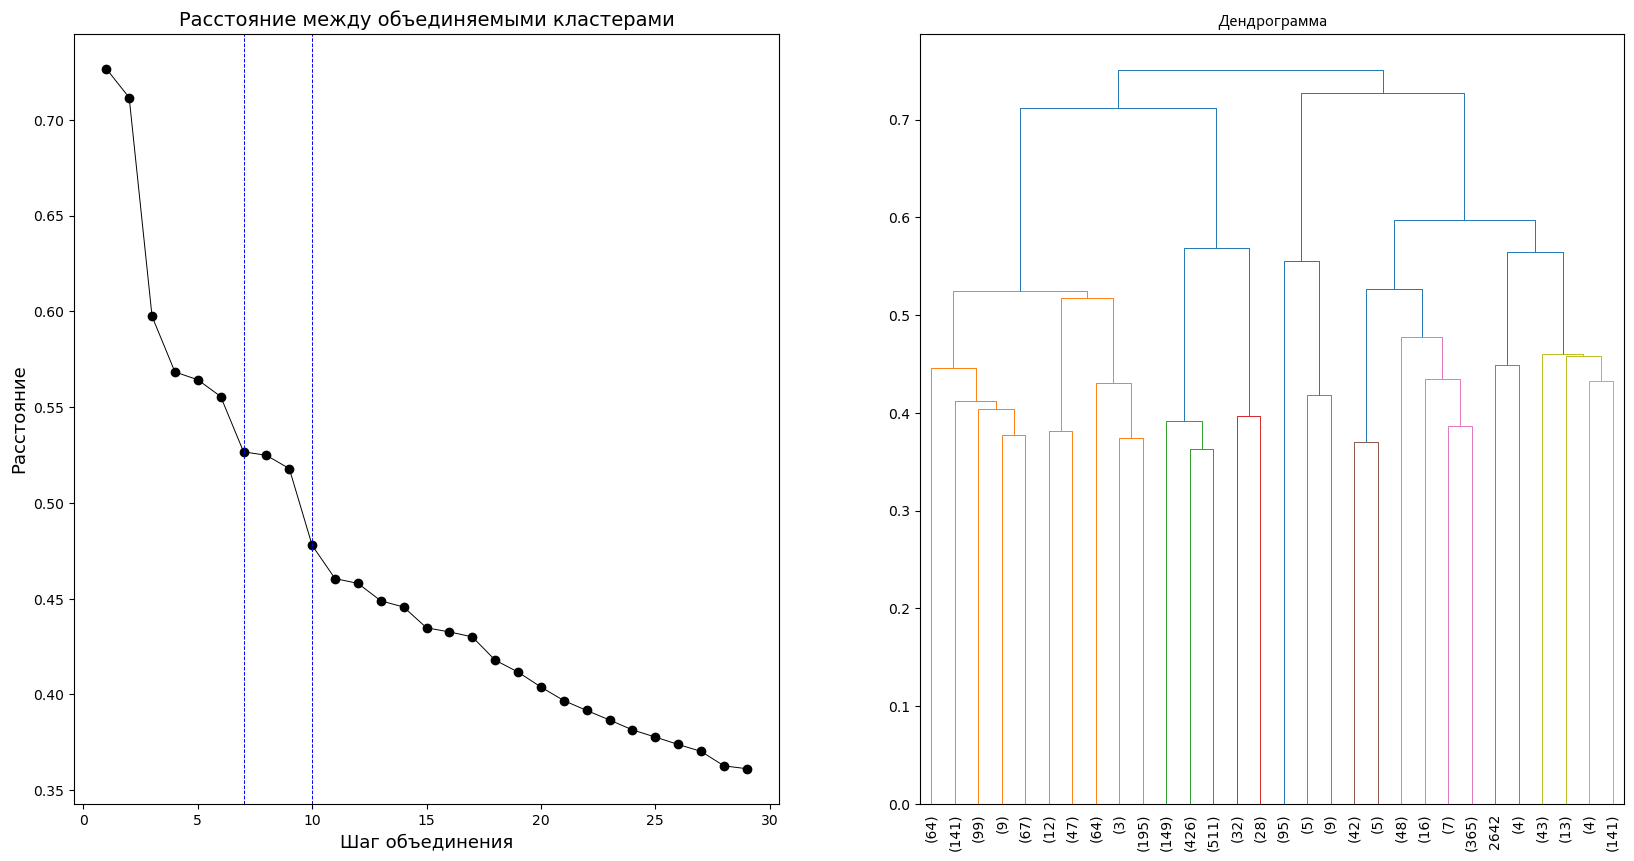

In [1267]:
Z = linkage(cdist_matrix, 'weighted')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# Построение каменистой осыпи
dist= Z[:, 2]
dist_rev = dist[::-1]
dist_rev_30 = dist_rev[1:30]
idxs = range(1, 30)
ax[0].plot(idxs, dist_rev_30, marker='o', color = 'k')
ax[0].set_title('Расстояние между объединяемыми кластерами', fontsize = 14)
ax[0].axvline(x = 7, color = 'b', linestyle = '--')
ax[0].axvline(x = 10, color = 'b', linestyle = '--')
ax[0].set_xlabel('Шаг объединения', fontsize = 13)
ax[0].set_ylabel('Расстояние', fontsize = 13)
ax[0].grid(False)

plt.rcParams['lines.linewidth'] = 0.7
font = {'fontname': 'Corbel', 'weight': 'normal', 'color':'black'}
plt.title('Дендрограмма', fontsize = 12, **font)

dn = dendrogram(Z,
               leaf_rotation=90,  
               leaf_font_size=10,
               truncate_mode='lastp',
               ax = ax[1])
plt.show()

##### 7 класетров

In [1269]:
# Добавим переменную с номерами кластеров
df['cluster'] = fcluster(Z, t = 0.56, criterion='distance')
gower_ward = df['cluster']
df

,Тип объекта,Подтип,Вариант оплаты,Состояние,Город,Цена за м2,cluster
0,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,33020.000,2
1,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,32596.000,2
2,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,32745.000,2
3,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,33803.500,2
4,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,43111.000,2
...,...,...,...,...,...,...,...
2640,Квартира,1к,100%,Регистрация,Москва,407371.195,7
2641,Квартира,Евро-4,Ипотека,Регистрация,Санкт-Петербург,297054.684,5
2642,Квартира,2к,Ипотека,Регистрация,Казань,361478.586,6
2643,Квартира,Евро-2,Рассрочка,Регистрация,Санкт-Петербург,269474.811,5


In [1270]:
categorical_cols = ['Тип объекта', 'Подтип', 'Вариант оплаты', 'Состояние', 'Город']
numeric_cols = ['Цена за м2']

# Средние числовые значения
print(df.groupby('cluster')[numeric_cols].mean())

# Мода категориальных
print(df.groupby('cluster')[categorical_cols].agg(lambda x: x.mode()[0]))


            Цена за м2
cluster               
1         59652.389258
2         42152.698537
3        309235.606233
4        306760.028174
5        290586.011304
6        249436.831400
7        374810.848358
         Тип объекта       Подтип Вариант оплаты    Состояние            Город
cluster                                                                       
1        Машиноместо  Стандартное           100%       Закрыт  Санкт-Петербург
2            Нежилое     Кладовая           100%       Закрыт  Санкт-Петербург
3            Нежилое    Коммерция      Рассрочка  Действующий  Санкт-Петербург
4        Апартаменты       Студия      Рассрочка  Действующий  Санкт-Петербург
5           Квартира           1к        Ипотека  Действующий  Санкт-Петербург
6           Квартира           2к        Ипотека  Действующий  Нижний Новгород
7           Квартира       Евро-2        Ипотека  Действующий           Москва


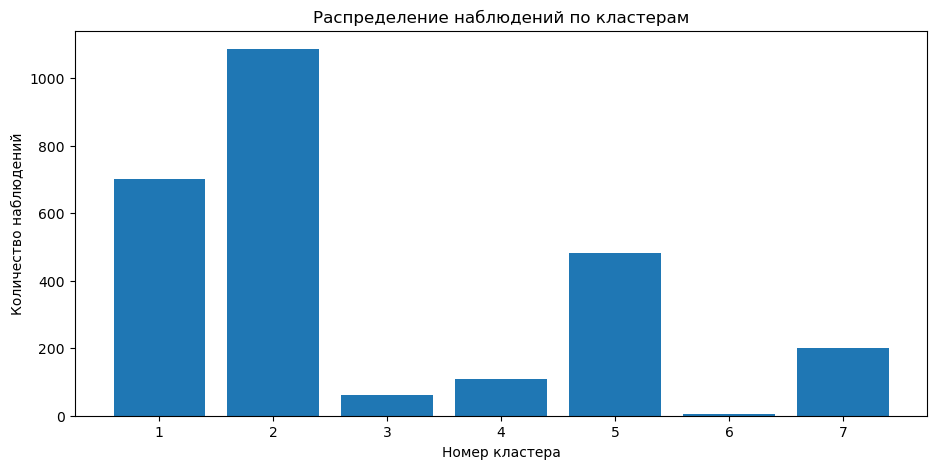

In [1271]:
# Подсчёт количества наблюдений в каждом кластере
cluster_counts = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(11, 5))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel("Номер кластера")
plt.ylabel("Количество наблюдений")
plt.title("Распределение наблюдений по кластерам")
plt.xticks(cluster_counts.index)
plt.show()

In [1272]:
cluster_counts

cluster
1     701
2    1086
3      60
4     109
5     483
6       5
7     201
Name: count, dtype: int64

In [1273]:
# удаляем столбец с номерами кластеров
df = df.drop(['cluster'], axis = 1)

##### 10 класетров

In [1275]:
# Добавим переменную с номерами кластеров
df['cluster'] = fcluster(Z, t = 0.52, criterion='distance')
gower_ward = df['cluster']
df

,Тип объекта,Подтип,Вариант оплаты,Состояние,Город,Цена за м2,cluster
0,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,33020.000,3
1,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,32596.000,3
2,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,32745.000,3
3,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,33803.500,3
4,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,43111.000,3
...,...,...,...,...,...,...,...
2640,Квартира,1к,100%,Регистрация,Москва,407371.195,10
2641,Квартира,Евро-4,Ипотека,Регистрация,Санкт-Петербург,297054.684,8
2642,Квартира,2к,Ипотека,Регистрация,Казань,361478.586,9
2643,Квартира,Евро-2,Рассрочка,Регистрация,Санкт-Петербург,269474.811,8


In [1276]:
categorical_cols = ['Тип объекта', 'Подтип', 'Вариант оплаты', 'Состояние', 'Город']
numeric_cols = ['Цена за м2']

# Средние числовые значения
print(df.groupby('cluster')[numeric_cols].mean())

# Мода категориальных
print(df.groupby('cluster')[categorical_cols].agg(lambda x: x.mode()[0]))

            Цена за м2
cluster               
1         59218.338097
2         60166.219293
3         42152.698537
4        309235.606233
5        249933.953084
6        692365.537714
7        263029.002277
8        293556.606314
9        249436.831400
10       374810.848358
         Тип объекта       Подтип Вариант оплаты    Состояние            Город
cluster                                                                       
1        Машиноместо  Стандартное           100%       Закрыт  Нижний Новгород
2        Машиноместо  Стандартное           100%  Действующий  Санкт-Петербург
3            Нежилое     Кладовая           100%       Закрыт  Санкт-Петербург
4            Нежилое    Коммерция      Рассрочка  Действующий  Санкт-Петербург
5        Апартаменты       Студия      Рассрочка  Действующий  Санкт-Петербург
6        Апартаменты       Евро-2           100%  Действующий           Казань
7           Квартира           1к           100%  Действующий  Санкт-Петербург
8           К

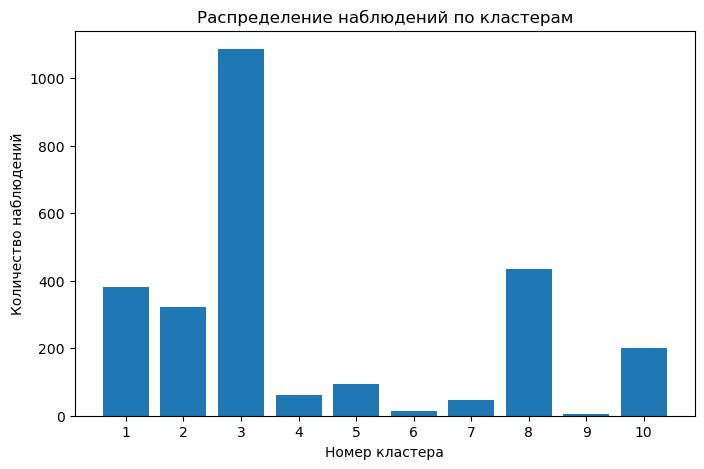

In [1277]:
# Подсчёт количества наблюдений в каждом кластере
cluster_counts = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel("Номер кластера")
plt.ylabel("Количество наблюдений")
plt.title("Распределение наблюдений по кластерам")
plt.xticks(cluster_counts.index)
plt.show()

In [1278]:
cluster_counts

cluster
1      380
2      321
3     1086
4       60
5       95
6       14
7       47
8      436
9        5
10     201
Name: count, dtype: int64

In [1279]:
# удаляем столбец с номерами кластеров
df = df.drop(['cluster'], axis = 1)

## K-modes / K-prototypes

<i> Huang, Z. (1997). A fast clustering algorithm to cluster very large categorical data sets in data mining. Dmkd, 3(8), 34-39.

<i> Cao, F., Liang, J, Bai, L.: A new initialization method for categorical data clustering, Expert Systems with Applications 36(7), pp. 10223-10228., 2009.

Модификация метода k-means алгоритм k-modes позволяет получить интерпретируемые кластеры при наличии категориальных переменных. Для смеси переменных наиболее подходящим является алгоритм <b>k-prototypes</b>, который для числовых переменных применяет евклидово расстояние, а для категориальных находит моду.

In [1282]:
# k-modes: https://pypi.org/project/kmodes/#huang97
# k-prototypes: https://codinginfinite.com/clustering-for-mixed-data-types-in-python/
!pip install kmodes

In [1283]:
pip install --upgrade kmodes

Note: you may need to restart the kernel to use updated packages.


In [1284]:
#from kmodes.kmodes import KModes 
from kmodes.kprototypes import KPrototypes

#### K-prototypes

In [1286]:
# стандартизация переменных 
# если данные не стандартизировать, кластеры формируются на основании значения переменной balance
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler() # z-метки

df3 = df.copy()
scaler.fit(df3[['Цена за м2']])
df3[['Цена за м2']] = scaler.transform(df[['Цена за м2']])

In [1287]:
df3.head()

,Тип объекта,Подтип,Вариант оплаты,Состояние,Город,Цена за м2
0,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,-0.738791
1,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,-0.741869
2,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,-0.740787
3,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург,-0.733103
4,Нежилое,Кладовая,100%,Действующий,Санкт-Петербург,-0.665537


In [1288]:
K = range(1, 18)
categorical_data = [0,1,2,3,4]

cost = []
for k in K:
    cost.append(KPrototypes(n_clusters = k, init = 'Cao', n_init = 1, gamma = None, verbose = 0, 
                      random_state = 42, n_jobs = 8).fit(df3, categorical = categorical_data).cost_)

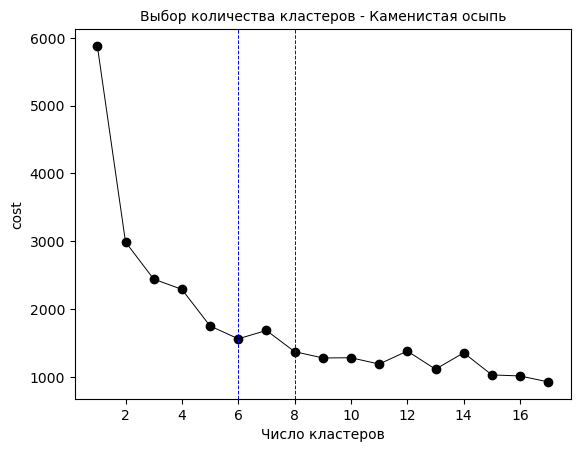

In [1289]:
# выбор количетсва кластеров
plt.figsize = (15, 10)
plt.title('Выбор количества кластеров - Каменистая осыпь', fontsize = 10)

plt.plot(K, cost, marker='o', color = 'k')
plt.axvline(x = 6, color = 'b', linestyle = '--')
plt.axvline(x = 8, color = 'b', linestyle = '--')
plt.xlabel('Число кластеров')
plt.ylabel('cost')

plt.show()

In [1290]:
kproto_6 = KPrototypes(n_clusters = 6, init = 'Cao', n_init = 1, gamma = None, verbose = 0, 
                      random_state = 42, n_jobs = 8).fit(df3, categorical = categorical_data)

In [1291]:
kproto_8= KPrototypes(n_clusters = 8, init = 'Cao', n_init = 1, gamma = None, verbose = 0, 
                      random_state = 42, n_jobs = 8).fit(df3, categorical = categorical_data)

##### 6 кластеров

In [1293]:
kproto_6_interpretation = pd.DataFrame(data = kproto_6.cluster_centroids_.T, index = ['Цена за м2', 'Тип объекта', 'Подтип', 'Вариант оплаты', 'Состояние', 'Город']).transpose()
kproto_6_interpretation

,Цена за м2,Тип объекта,Подтип,Вариант оплаты,Состояние,Город
0,1.8867842303068991,Квартира,Евро-2,Ипотека,Действующий,Санкт-Петербург
1,-0.6345071889535353,Машиноместо,Стандартное,100%,Закрыт,Нижний Новгород
2,0.9158455660374271,Квартира,Студия,Ипотека,Действующий,Санкт-Петербург
3,-0.6103020152796034,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург
4,-0.4724983586849315,Машиноместо,Стандартное,100%,Действующий,Санкт-Петербург
5,-0.714206204338592,Нежилое,Кладовая,100%,Закрыт,Санкт-Петербург


In [1294]:
df['cluster'] = kproto_6.labels_

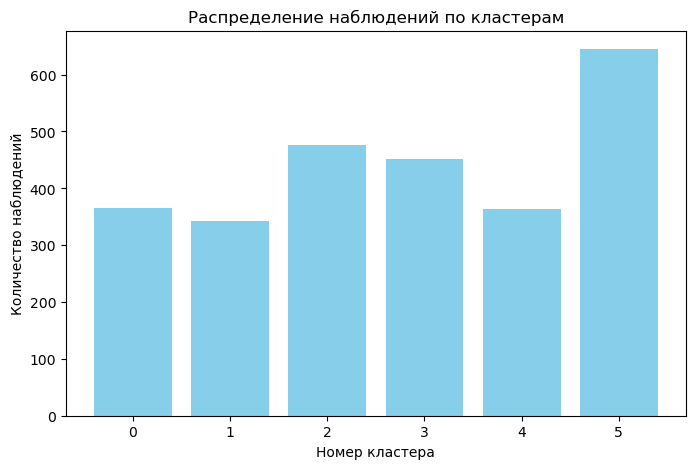

In [1295]:
cluster_counts = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel("Номер кластера")
plt.ylabel("Количество наблюдений")
plt.title("Распределение наблюдений по кластерам")
plt.xticks(cluster_counts.index)
plt.show()

In [1296]:
categorical_cols = ['Тип объекта', 'Подтип', 'Вариант оплаты', 'Состояние', 'Город']
numeric_cols = ['Цена за м2']

# Средние числовые значения
print(df.groupby('cluster')[numeric_cols].mean())

# Мода категориальных
print(df.groupby('cluster')[categorical_cols].agg(lambda x: x.mode()[0]))

            Цена за м2
cluster               
0        394702.286603
1         47385.436580
2        260952.036289
3         50719.785244
4         69702.728495
5         36406.614076
         Тип объекта       Подтип Вариант оплаты    Состояние            Город
cluster                                                                       
0           Квартира       Евро-2        Ипотека  Действующий  Санкт-Петербург
1        Машиноместо  Стандартное           100%       Закрыт  Нижний Новгород
2           Квартира       Студия        Ипотека  Действующий  Санкт-Петербург
3            Нежилое     Кладовая      Рассрочка  Действующий  Санкт-Петербург
4        Машиноместо  Стандартное           100%  Действующий  Санкт-Петербург
5            Нежилое     Кладовая           100%       Закрыт  Санкт-Петербург


##### 8 кластеров

In [1298]:
kproto_8_interpretation = pd.DataFrame(data = kproto_8.cluster_centroids_.T, index = ['Цена за м2', 'Тип объекта', 'Подтип', 'Вариант оплаты', 'Состояние', 'Город']).transpose()
kproto_8_interpretation

,Цена за м2,Тип объекта,Подтип,Вариант оплаты,Состояние,Город
0,0.8947040089683113,Апартаменты,Студия,Рассрочка,Действующий,Санкт-Петербург
1,-0.6345071889535352,Машиноместо,Стандартное,100%,Закрыт,Нижний Новгород
2,1.807613065824599,Квартира,Евро-2,Ипотека,Действующий,Санкт-Петербург
3,-0.6064029862968755,Нежилое,Кладовая,Рассрочка,Действующий,Санкт-Петербург
4,-0.46980329898701206,Машиноместо,Стандартное,100%,Действующий,Санкт-Петербург
5,3.8344186945867356,Апартаменты,Евро-2,Ипотека,Действующий,Казань
6,1.0628332874382425,Квартира,1к,Ипотека,Действующий,Санкт-Петербург
7,-0.713959755699375,Нежилое,Кладовая,100%,Закрыт,Санкт-Петербург


In [1299]:
df['cluster'] = kproto_8.labels_

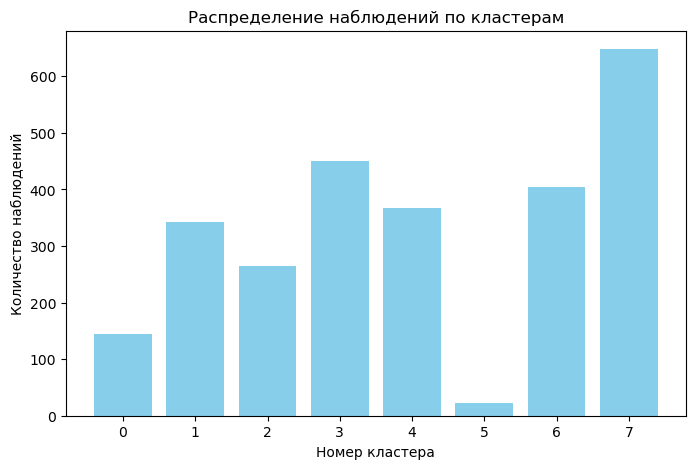

In [1300]:
cluster_counts = df['cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel("Номер кластера")
plt.ylabel("Количество наблюдений")
plt.title("Распределение наблюдений по кластерам")
plt.xticks(cluster_counts.index)
plt.show()

In [1301]:
cluster_counts

cluster
0    145
1    343
2    264
3    450
4    367
5     23
6    405
7    648
Name: count, dtype: int64

In [1302]:
categorical_cols = ['Тип объекта', 'Подтип', 'Вариант оплаты', 'Состояние', 'Город']
numeric_cols = ['Цена за м2']

# Средние числовые значения
print(df.groupby('cluster')[numeric_cols].mean())

# Мода категориальных
print(df.groupby('cluster')[categorical_cols].agg(lambda x: x.mode()[0]))

            Цена за м2
cluster               
0        258039.711697
1         47385.436580
2        383796.177436
3         51256.890338
4         70073.982542
5        662995.853130
6        281200.117094
7         36440.563252
         Тип объекта       Подтип Вариант оплаты    Состояние            Город
cluster                                                                       
0        Апартаменты       Студия      Рассрочка  Действующий  Санкт-Петербург
1        Машиноместо  Стандартное           100%       Закрыт  Нижний Новгород
2           Квартира       Евро-2        Ипотека  Действующий  Санкт-Петербург
3            Нежилое     Кладовая      Рассрочка  Действующий  Санкт-Петербург
4        Машиноместо  Стандартное           100%  Действующий  Санкт-Петербург
5        Апартаменты       Евро-2        Ипотека  Действующий           Казань
6           Квартира           1к        Ипотека  Действующий  Санкт-Петербург
7            Нежилое     Кладовая           100%       Закр